#### Homography is a projective transformation. For a 2d projective transform, after homogenization of coordinates, we get a matrix with 8 unknowns. Hence we need 4 points in each image at minimum to compute the homography between them.
#### The four points will result in 8 equations, using which, we can solve the homography H $$Hx_i = x_i', i \in [1, 4]$$
#### H = $\begin{bmatrix} h_1 & h_2 & h_3 \\ h_4 & h_5 & h_6 \\ h_7 & h_8 & h_9 \end{bmatrix}$, setting one element $h_9 = 1$ leaves us with 8 degrees of freedom.
#### Now, to solve this system of equations
#### A = $\begin{bmatrix} x_1 & y_1 & 1 & 0 & 0 & 0 & -x_1x_1' & -y_1x_1' \\ 0 & 0 & 0 & x_1 & y_1 & 1 & -x_1y_1' & -y_1y_1' \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\ x_n & y_n & 1 & 0 & 0 & 0 & -x_nx_n' & -y_nx_n' \\ 0 & 0 & 0 & x_n & y_n & 1 & -x_ny_n' & -y_ny_n' \end{bmatrix}$ h = $\begin{bmatrix} h_1 \\ h_2 \\ h_3 \\ \vdots \\ h_8 \end{bmatrix}$ c = $\begin{bmatrix} x_1' \\ y_1' \\ \vdots \\ x_N' \\ y_N' \end{bmatrix}$

#### In our case, N = 4. Since A is then a square matric, we can solve for $$h = A^{-1}c$$

In [76]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mtplt
import numpy as np
import cv2
import math

## Homography Class

In [77]:
class Homography:
    def __init__(self):
        pass

    def get_images_scene_augmentation(self):
        # Load images
        self.poster_image = mpimg.imread('HW2_image1.jpg')
        self.poster_image = np.rot90(self.poster_image, 2)
        self.wall_image = mpimg.imread('HW2_image2.jpg')

        # Create subplots with 1 row and 2 columns
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Display the first image (poster_image)
        axs[0].imshow(self.poster_image, origin='upper')
        axs[0].axis('off')  # Hide axes for the first image
        axs[0].set_title('Poster Image')

        # Display the second image (wall_image)
        axs[1].imshow(self.wall_image, origin='upper')
        axs[1].axis('off')  # Hide axes for the second image
        axs[1].set_title('Wall Image')

        # Show the plot with both images
        plt.show()

    def get_points_for_scene_augmentation(self, num_points):
        # To allow an interactive display of images for clicking and manually getting the points.
        mtplt.use('TkAgg')

        # Click points on image1
        plt.imshow(self.poster_image)
        self.poster_points = plt.ginput(num_points)
        print(self.poster_points)

        # Click points on image2
        plt.imshow(self.wall_image)
        self.wall_points = plt.ginput(num_points)
        print(self.wall_points)


    def get_images_for_stitching(self, downsampling_factor):
        self.images = []


        # TODO(KSorte): Make this less hard coded.
        # self.images.append(cv2.imread('image_stitching_img1.jpeg'))
        # self.images.append(cv2.imread('image_stitching_img2.jpeg'))
        # self.images.append(cv2.imread('image_stitching_img3.jpeg'))

        # self.images.append(cv2.imread('ML_Playground3_1.jpeg'))
        # self.images.append(cv2.imread('ML_Playground3_2.jpeg'))
        # self.images.append(cv2.imread('ML_Playground3_3.jpeg'))

        self.images.append(cv2.imread('ML_Playground1_1.jpeg'))
        self.images.append(cv2.imread('ML_Playground1_2.jpeg'))
        self.images.append(cv2.imread('ML_Playground1_3.jpeg'))
        self.images.append(cv2.imread('ML_Playground1_4.jpeg'))

        # self.images.append(cv2.imread('FisherAve_1.jpeg'))
        # self.images.append(cv2.imread('FisherAve_2.jpeg'))
        # self.images.append(cv2.imread('FisherAve_3.jpeg'))


        for i in range(len(self.images)):
            new_width = self.images[i].shape[1] // downsampling_factor
            new_height = self.images[i].shape[0] // downsampling_factor
            self.images[i] = cv2.resize(self.images[i], (new_width, new_height), interpolation=cv2.INTER_LINEAR)

            # Convert images to RGB for Matplotlib (OpenCV loads in BGR format)
            self.images[i] = cv2.cvtColor(self.images[i], cv2.COLOR_BGR2RGB)

        # Assign a central image that will not be warped.
        self.central_image_index = len(self.images)//2

        # Plot.
        for image in self.images:
            plt.imshow(image)
            plt.show()


    def get_points_for_image_stitching(self, num_points, use_file = False, filename = ''):
        mtplt.use('TKAgg')
        self.homography_points = []

        # Using pre-captured points.
        if use_file:
            self.homography_points_array = np.load(filename)
            return

        for i in range(len(self.images) - 1):
            pair_of_overlap_points = []
            # Get overlapping points for two images at a time from left to right.
            plt.imshow(self.images[i])
            pair_of_overlap_points.append(plt.ginput(num_points))

            plt.imshow(self.images[i+1])
            pair_of_overlap_points.append(plt.ginput(num_points))

            # Add points to list.
            self.homography_points.append(pair_of_overlap_points)

            self.homography_points_array = np.array([np.stack(pair, axis=0) for pair in self.homography_points])

            # Save the array
            np.save(filename, self.homography_points_array)


    def compute_homography(self, source_points, destination_points):
        # Get number of points.
        num_points = len(source_points)

        # Construct the system of linear equations for computing homography of the form Ah = C
        # Assuming that the bottom right element of the homography is 1, giving 8 DOF.
        A = np.zeros((2*num_points, 8))

        C = np.zeros(2*num_points)
        C = C.reshape(-1, 1)

        # Populate A.
        for i in range(num_points):
            # Fill the 2*i th row
            x1 = source_points[i][0]
            y1 = source_points[i][1]

            x2 = destination_points[i][0]
            y2 = destination_points[i][1]

            A[2*i, :] = [
                x1, y1, 1, 0, 0, 0, -x1*x2, -x2*y1
            ]

            C[2*i] = x2

            A[2*i+1, :] = [
                0, 0, 0, x1, y1, 1, -y2*x1, -y2*y1
            ]

            C[2*i + 1] = y2

        # Compute psuedo inverse of A to get h.
        h = np.linalg.inv((A.T@A))@(A.T@C)


        H = np.append(h, 1).reshape(3, 3)
        return H

    def compute_homographies_image_stitching(self):
        self.homographies_image_stitching = []
        for matching_points in self.homography_points_array:
            self.homographies_image_stitching.append(self.compute_homography(matching_points[0], matching_points[1]))

        # Identity homography for central image.
        self.homographies_image_stitching.insert(self.central_image_index, np.eye(3))

        # Adjust homographies for all right images to bring into central plane.
        for i in range(self.central_image_index + 1, len(self.homographies_image_stitching)):
            # Adjust homographies
            self.homographies_image_stitching[i] = self.homographies_image_stitching[i-1]@ \
                                                    np.linalg.inv(self.homographies_image_stitching[i])

        # Adjust homographies for left images to bring into central plane.
        for i in range(self.central_image_index-1, -1, -1):
            # Adjusted homography.
            self.homographies_image_stitching[i] = self.homographies_image_stitching[i]@ \
                                                    self.homographies_image_stitching[i+1]

    def transform_image_corners(self, image, H):
        # Get image corner points coordinates.
        img_corner_points = np.array(
            [[0, 0],
             [image.shape[1], 0],
             [image.shape[1],image.shape[0]],
             [0, image.shape[0]]], dtype=np.float32)

        # Transform and reshape.
        transformed_points = cv2.perspectiveTransform(img_corner_points.reshape((1, -1, 2)), H)
        transformed_points = transformed_points.reshape(-1, 2)

        xcoords = transformed_points[:, 0]
        ycoords = transformed_points[:, 1]

        # Find xmin, xmax, ymin, ymax
        xmin = np.min(xcoords)
        xmax = np.max(xcoords)
        ymin = np.min(ycoords)
        ymax = np.max(ycoords)
        return transformed_points, xmin, ymin, xmax, ymax

    # Get size of the canvas on which panorama displayed
    def get_panorama_canvas(self):
        # Get image corner points after transforming images on central plane.
        self.transformed_img_corners = []

        self.xmin_canvas = float('inf')
        self.ymin_canvas = float('inf')
        self.xmax_canvas = float('-inf')
        self.ymax_canvas = float('-inf')

        for i in range(len(self.images)):
            img_corners, xmin, ymin, xmax, ymax = self.transform_image_corners(
                 self.images[i], self.homographies_image_stitching[i])

            self.xmin_canvas = min(xmin, self.xmin_canvas)
            self.ymin_canvas = min(ymin, self.ymin_canvas)
            self.xmax_canvas = max(xmax, self.xmax_canvas)
            self.ymax_canvas = max(ymax, self.ymax_canvas)
            self.transformed_img_corners.append(img_corners)

        self.canvas_x_size = math.ceil(self.xmax_canvas - self.xmin_canvas)
        self.canvas_y_size = math.ceil(self.ymax_canvas - self.ymin_canvas)

    def project_images_on_canvas(self):
        # Initialize empty canvas
        self.canvas = np.zeros((self.canvas_y_size, self.canvas_x_size, 3), dtype=np.uint8)
        self.canvas[:] = (0, 0, 0)

        # Translation matrix
        T = np.array([[1, 0, abs(self.xmin_canvas)],
                     [0, 1, abs(self.ymin_canvas)],
                     [0, 0, 1]])

        # Put Images on canvas.
        for i in range(len(self.images)):
            H = self.homographies_image_stitching[i]
            img = self.images[i]

            warped_img = cv2.warpPerspective(np.copy(img), T @ H,
                                        (self.canvas_x_size, self.canvas_y_size))

            corner_pts_warped_img, _, _, _, _ = self.transform_image_corners(self.images[i], T@H)
            corner_pts_warped_img = corner_pts_warped_img.reshape(-1, 1, 2)
            self.canvas = cv2.fillPoly(self.canvas, [corner_pts_warped_img.astype(int)], 0)

            self.canvas = cv2.bitwise_or(warped_img, self.canvas)

        # Plot canvas
        plt.imshow(self.canvas)
        plt.show()

    def get_panorama(self):
        self.compute_homographies_image_stitching()
        self.get_panorama_canvas()
        self.project_images_on_canvas()

    def place_source_image_into_destination(self, source_image, destination_image, dest_image_points, homography):
        # Create an image matrix of size equal to destination and warp the source image into it,
        # using the computed homography.
        warped_image = cv2.warpPerspective(source_image, homography,(destination_image.shape[1],destination_image.shape[0]))

        # Mask the poster image inside the polygon given by the selected points.
        masked_image = cv2.fillPoly(destination_image.copy(), [dest_image_points.astype(int)], 0)

        # # Bitwise or to combine the warped image and the masked image.
        overlayed_image = cv2.bitwise_or(warped_image, masked_image)

        return overlayed_image


## Scene Augmentation

Images for scene augementation exercise


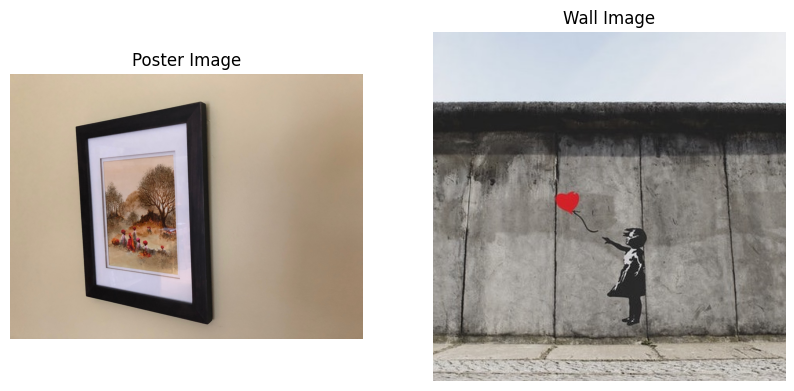

[(926.0104052573932, 461.78258488499455), (531.7059145673605, 499.89868565169786), (568.5076670317636, 1082.1549835706462), (950.9830230010954, 1133.4145673603505)]
[(447.42633738416873, 0.942236478381119), (1.5736626158312674, 1.329934456440526), (0.41056868165298965, 444.0810254003025), (448.589431318347, 442.1425355100054)]
Computed Homography =  [[ 5.95356265e-01  1.42736219e-01  5.30389946e+02]
 [-2.28257805e-01  1.42457711e+00  4.98185365e+02]
 [-3.11826294e-04  1.01345134e-04  1.00000000e+00]]

 Computed Homography by CV2 function =  (array([[ 5.95356469e-01,  1.42736108e-01,  5.30389964e+02],
       [-2.28257639e-01,  1.42457699e+00,  4.98185361e+02],
       [-3.11825984e-04,  1.01344914e-04,  1.00000000e+00]]), array([[1],
       [1],
       [1],
       [1]], dtype=uint8))

 Overlayed source image on the destimation image:


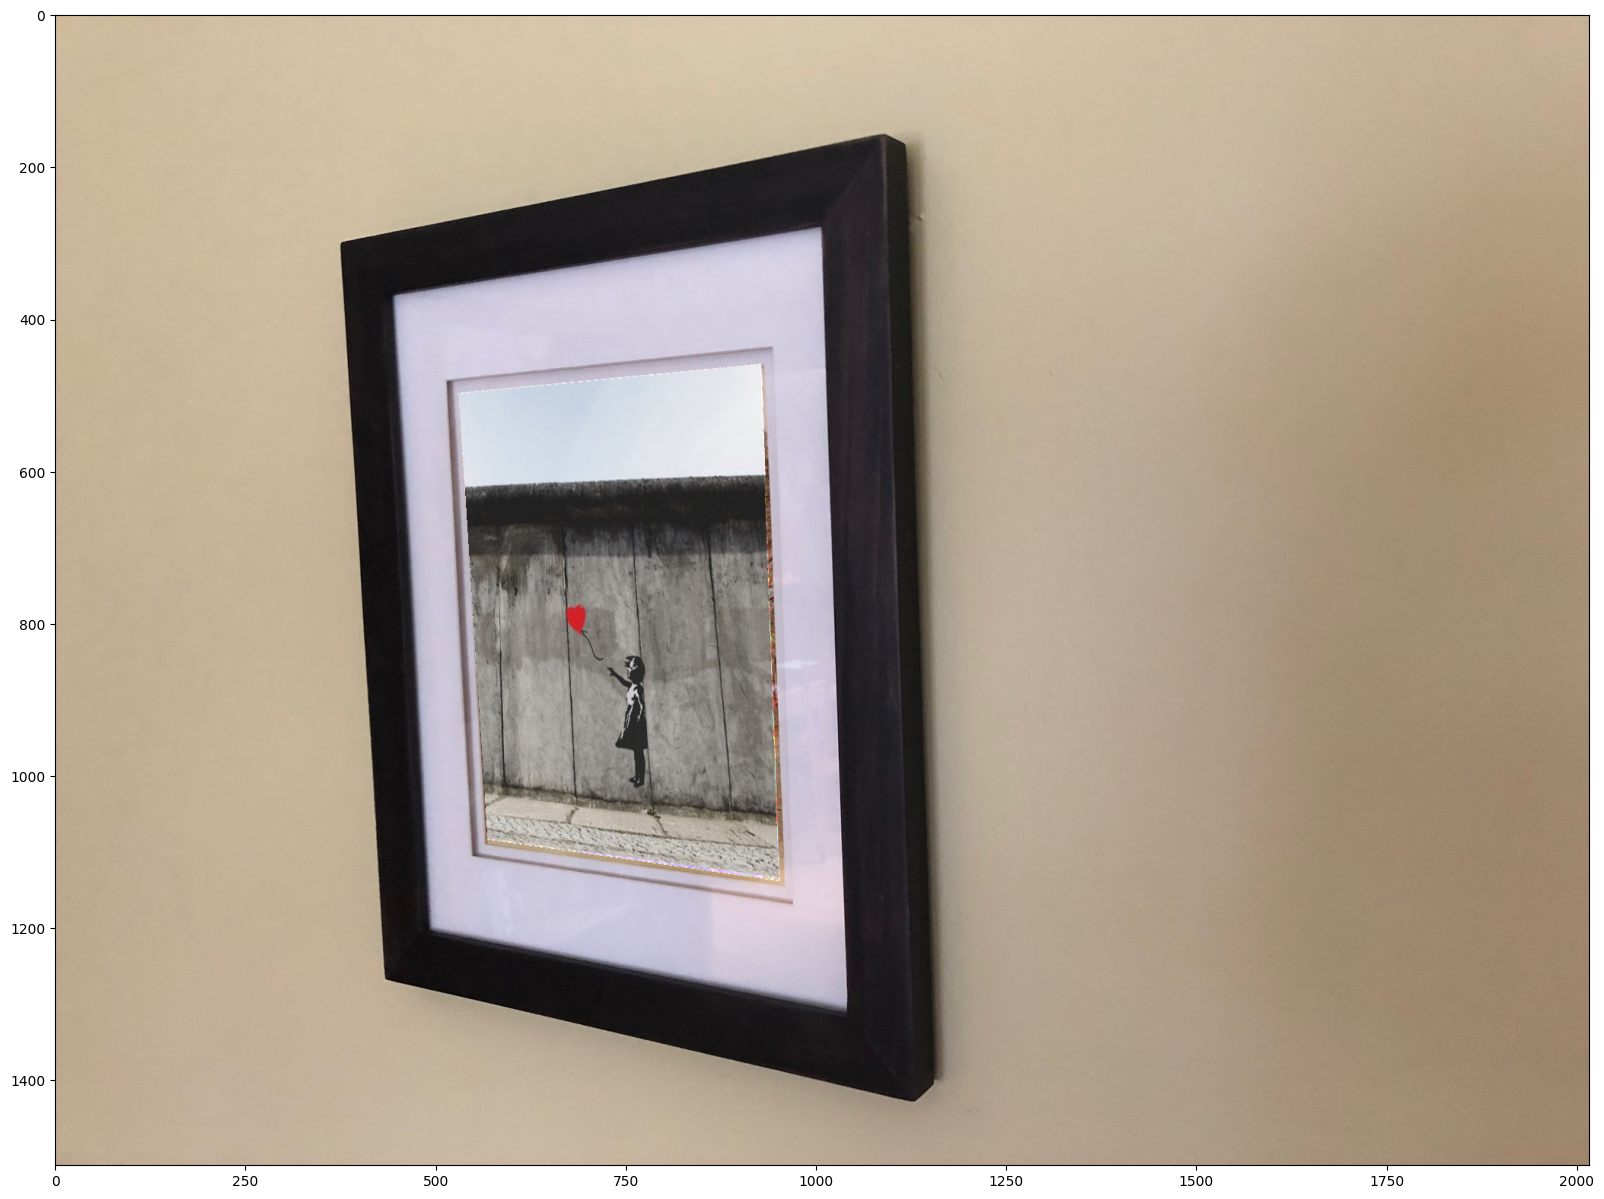

In [78]:
%matplotlib inline
homography = Homography()

print("Images for scene augementation exercise")
homography.get_images_scene_augmentation()

homography.get_points_for_scene_augmentation(4)
H = homography.compute_homography(homography.wall_points, homography.poster_points)
print("Computed Homography = ", H)


# Convert points to numpy arrays
poster_points = np.array(homography.poster_points, dtype='float32')
wall_points = np.array(homography.wall_points, dtype='float32')

# Convert to the shape required by cv2.findHomography
poster_points_for_cv2 = poster_points.reshape(-1, 1, 2)
wall_points_for_cv2 = wall_points.reshape(-1, 1, 2)

overlayed_image = homography.place_source_image_into_destination(homography.wall_image, homography.poster_image, poster_points_for_cv2, H)

H1 = cv2.findHomography(wall_points_for_cv2, poster_points_for_cv2)
print("\n Computed Homography by CV2 function = ", H1)

print("\n Overlayed source image on the destimation image:")
plt.imshow(overlayed_image)
plt.show()

## Image Stitching : Panorama

### Get Images

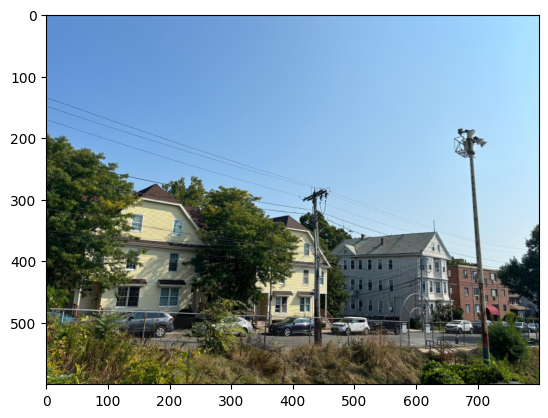

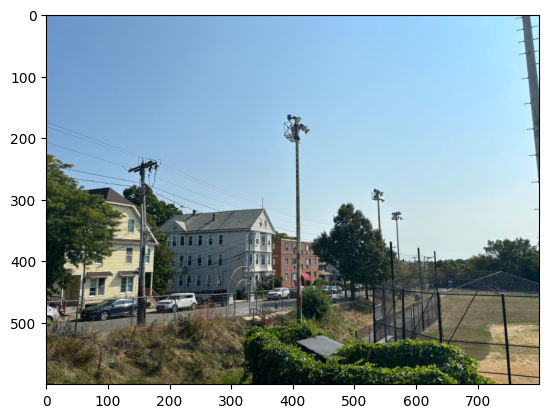

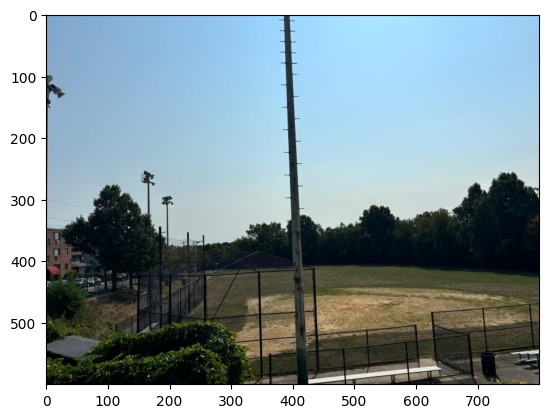

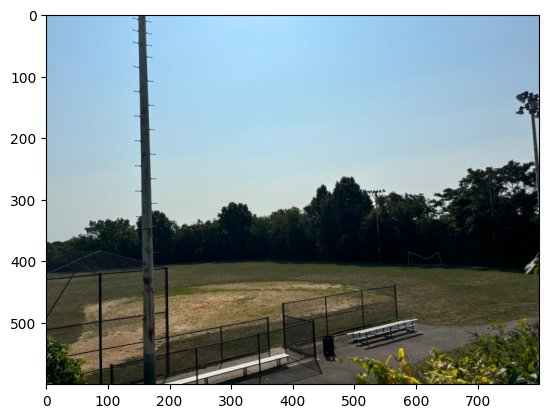

In [79]:
%matplotlib inline
homography = Homography()

homography.get_images_for_stitching(downsampling_factor=2)

### Manually pick overalapping points for image stitching

In [80]:
homography.get_points_for_image_stitching(num_points=4, use_file=True, filename="homography_points_MP_Playground1.npy")

## Get Panorama and Plot

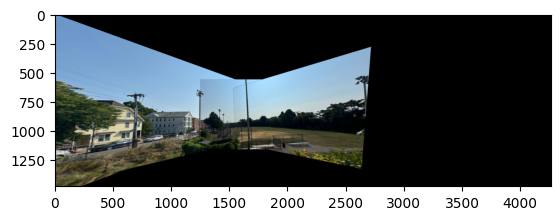

In [81]:
%matplotlib inline
homography.get_panorama()